In [1]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
#!pip install matplotlib
#!pip install scikit-learn
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 4.9 MB/s eta 0:00:00a 0:00:01


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import Callback
import random 
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.resnet50 import ResNet50 
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [11]:
seed_value = 42
random.seed(seed_value)  # Python
np.random.seed(seed_value)  # NumPy
tf.random.set_seed(seed_value)  # TensorFlow

In [12]:
train_dir = "dataset/train"
val_dir = "dataset/validation"

In [37]:
batch_size = 4
img_height, img_width = 500 , 500

In [38]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=3,         
    width_shift_range=0.1,     
    height_shift_range=0.1,   
    zoom_range=0.2,         
    brightness_range=[0.8, 1.2],
    shear_range=0.2,      
    horizontal_flip=False,
    vertical_flip=False
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [39]:
def visualize_dataset(ds):

    # Dictionary to hold sampled images for each class
    sampled_images = {class_name: [] for class_name in ds.class_indices.keys()}
    
    # Extract all images and labels from the dataset
    for images, labels in ds:
        for img, label in zip(images, labels):
            class_index = np.argmax(label)
            class_name = list(ds.class_indices.keys())[class_index]
            
            # Add the image if we have less than 3 for this class
            if len(sampled_images[class_name]) < 3:
                sampled_images[class_name].append(img)
            
            # Stop if we have 3 images per class
            if all(len(imgs) == 3 for imgs in sampled_images.values()):
                break
        if all(len(imgs) == 3 for imgs in sampled_images.values()):
            break
    
    # Plot 3 images per class
    classes = list(ds.class_indices.keys())
    fig, axes = plt.subplots(len(classes), 3, figsize=(12, len(classes) * 4))
    
    for i, class_name in enumerate(classes):
        for j in range(3):
            axes[i, j].imshow(sampled_images[class_name][j].astype("uint8"))
            axes[i, j].axis("off")
            if j == 1:  # Center column for class name
                axes[i, j].set_title(class_name, fontsize=14)
    
    plt.tight_layout()
    plt.show()


In [40]:
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
    )

Found 243 images belonging to 3 classes.


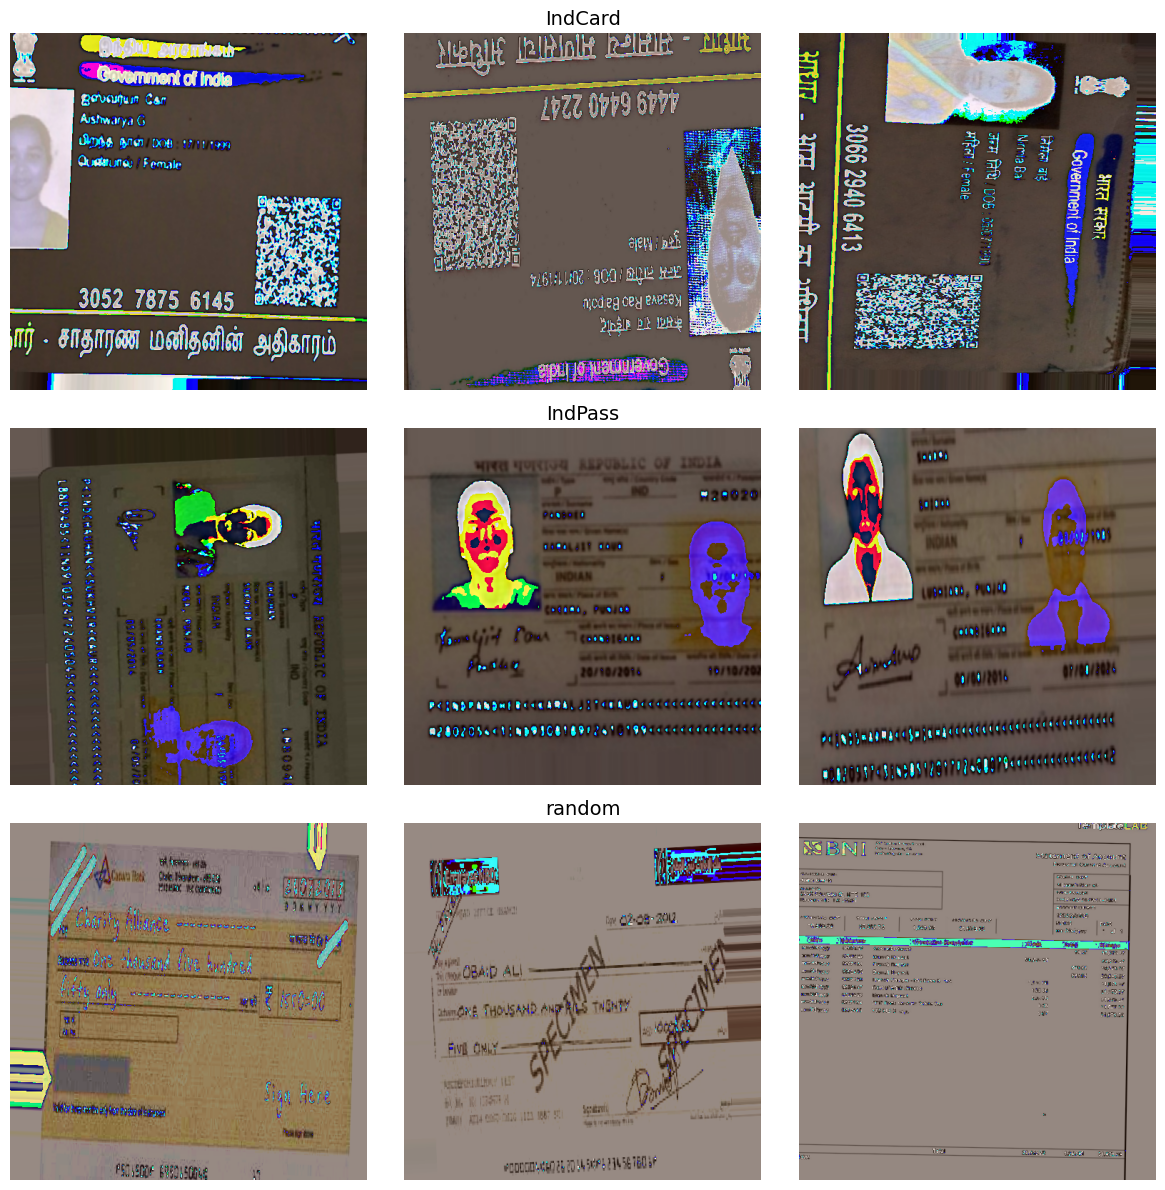

In [41]:
visualize_dataset(train_ds)

In [42]:
val_ds = train_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
    )

Found 60 images belonging to 3 classes.


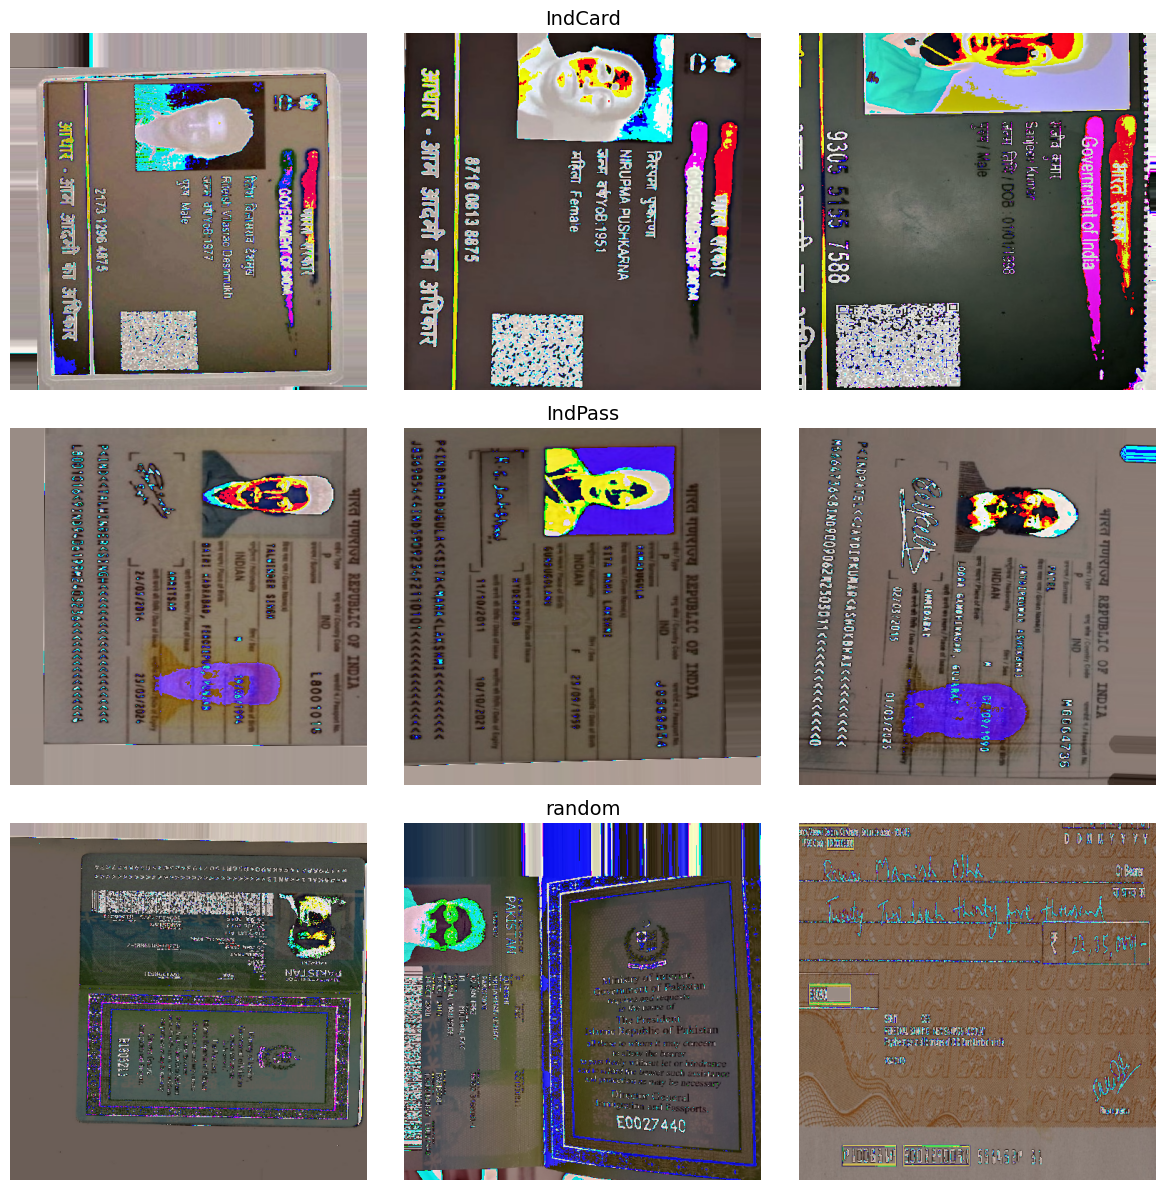

In [43]:
visualize_dataset(val_ds)

In [44]:
train_ds.image_shape

(500, 500, 3)

In [45]:
num_classes = 3

In [46]:
resnet= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_height,img_width,3),
                   pooling='avg',
                   weights='imagenet')
for layer in resnet.layers:
        layer.trainable=False

In [47]:
# Determine 70% of the layers
num_layers_to_freeze = int(0.70* len(resnet.layers))

# Freeze the first 70% of layers
for i, layer in enumerate(resnet.layers):
    if i < num_layers_to_freeze:
        layer.trainable = False

In [48]:
model = Sequential([ 
    resnet,
    layers.Flatten(), 
    layers.Dense(448, activation='relu',kernel_regularizer=l2(1e-5)),
    layers.Dense(240, activation='relu',kernel_regularizer=l2(1e-5)),
    layers.Dense(112, activation='relu',kernel_regularizer=l2(1e-5)),
    layers.Dropout(0.3), 
    layers.Dense(num_classes, activation='softmax')])

In [49]:
model.summary() 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 448)            │       917,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 240)            │       107,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 112)            │        26,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           339 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,640,755 (94.00 MB)

 Trainable params: 1,053,043 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [50]:
model.compile(optimizer=Adam(learning_rate=4e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"] 
             )

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [51]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [52]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[early_stopping,lr_scheduler] 
  )

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 38s 449ms/step - accuracy: 0.6564 - loss: 0.7670 - val_accuracy: 0.8667 - val_loss: 0.2640 - learning_rate: 4.0000e-04
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 31s 361ms/step - accuracy: 0.9424 - loss: 0.1791 - val_accuracy: 1.0000 - val_loss: 0.0350 - learning_rate: 4.0000e-04
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 21s 345ms/step - accuracy: 0.9828 - loss: 0.0534 - val_accuracy: 0.9333 - val_loss: 0.1464 - learning_rate: 4.0000e-04
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 369ms/step - accuracy: 1.0000 - loss: 0.0309 - val_accuracy: 0.9833 - val_loss: 0.0459 - learning_rate: 4.0000e-04
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.9991 - loss: 0.0155 - val_accuracy: 1.0000 - val_loss: 0.0286 - learning_rate: 2.0000e-04
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 356ms/step - accuracy: 0.9850 - loss: 0.0302 - val_accuracy: 1.0000 - val_loss: 0.0152 - learning_rate: 2.0000e-04
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 22s 354ms/step - acc

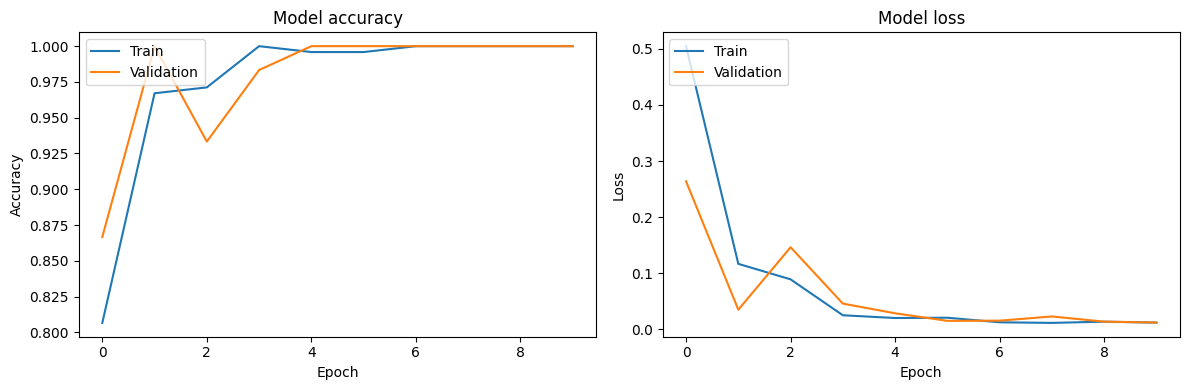

In [53]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [54]:
model.save("models/model_0.h5")